In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
import statistics

In [8]:
########################################################### load climatology dataset ############################################################
clim_z500 = xr.open_dataset('/home/kit/imktro/gj5173/tmp/clim_Z50000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')


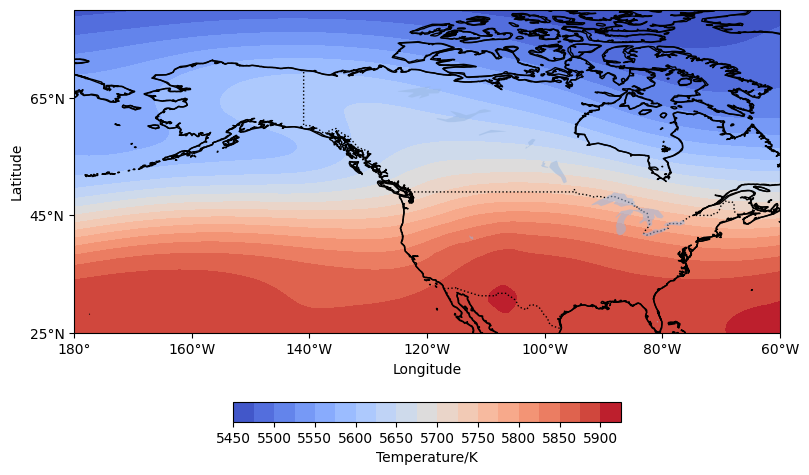

In [9]:
#check for the distribution of climatology of z500



lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map
contour1 = ax.contourf(x,y,clim_z500.Z/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='Temperature/K',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [10]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [11]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [12]:
ds_era5_z500_na

<xarray.DataArray 'fields' (phony_dim_0: 21, phony_dim_2: 220, phony_dim_3: 480)> Size: 9MB
[2217600 values with dtype=float32]
Dimensions without coordinates: phony_dim_0, phony_dim_2, phony_dim_3

In [13]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [14]:
#interpolate the era5 data onto the climatology data 
ds_era5_z500_na_0629_interpolated = interpolate_function(ds_era5_z500_na_0629,clim_z500)

In [15]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [16]:
ds_era5_z500_na_0629_interpolated.shape

(110, 240)

In [17]:
#calculate the anomaly by batch difference function

v2 = ds_era5_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:].values

anomaly_era5_z500_na_0629_interpolated = calculate_batch_difference(v1, v2, 50)



In [18]:
%store anomaly_era5_z500_na_0629_interpolated

Stored 'anomaly_era5_z500_na_0629_interpolated' (ndarray)


In [31]:
############################################## load the ECMWF data---control forecast ############################################################

In [12]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [13]:
def process_target_forecast(ds, start_index, step_size, num_iterations):
    'choose the certain date and lead time and get the target forecast'
    ds_target_forecast = []
    for i in range(num_iterations):
        ec_value = ds[(i + 1) * step_size, start_index - i * step_size * 4, :, :]
        ds_target_forecast.append(ec_value)

    ds_target_forecast = xr.DataArray(ds_target_forecast)

    return ds_target_forecast
'''#usage example
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_box
ds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'''

'#usage example\nstart_index = 56\nstep_size = 1\nnum_iterations = 15\nds=ds_ec_t2m_box\nds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'

In [14]:
#read data and choose variable----z500
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'
variable_name = 'z'
level = 2  # 500hpa
ds_ec_z500_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_z500_box=ds_ec_z500_na[:,:,79:159,194:274]

In [15]:
#choose the target day in the whole NA area
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_z500_na
ds_ec_z500_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [29]:
%store ds_ec_z500_na_0629

Stored 'ds_ec_z500_na_0629' (DataArray)


In [36]:
########################################## load the ECMWF data ----- predictability froecast ########################################################

In [16]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_pl.nc') 
variable_data_ec_1 = ds_ec_1['z'][56,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_pl.nc') 
variable_data_ec_2 = ds_ec_2['z'][52,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_pl.nc') 
variable_data_ec_3 = ds_ec_3['z'][48,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_pl.nc') 
variable_data_ec_4 = ds_ec_4['z'][44,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_pl.nc') 
variable_data_ec_5 = ds_ec_5['z'][40,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_pl.nc') 
variable_data_ec_6 = ds_ec_6['z'][36,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_pl.nc') 
variable_data_ec_7 = ds_ec_7['z'][32,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_pl.nc') 
variable_data_ec_8 = ds_ec_8['z'][28,:,2,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_pl.nc') 
variable_data_ec_9 = ds_ec_9['z'][24,:,2,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_pl.nc') 
variable_data_ec_10 = ds_ec_10['z'][20,:,2,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_pl.nc') 
variable_data_ec_11 = ds_ec_11['z'][16,:,2,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_pl.nc') 
variable_data_ec_12 = ds_ec_12['z'][12,:,2,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_pl.nc') 
variable_data_ec_13 = ds_ec_13['z'][8,:,2,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_pl.nc') 
variable_data_ec_14 = ds_ec_14['z'][4,:,2,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_pl.nc') 
variable_data_ec_15 = ds_ec_15['z'][0,:,2,:,:]

In [17]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [18]:
ds_ec_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [19]:
ds_ec_z500_na_0629_ens = xr.DataArray(ds_ec_z500_na_0629_ens)

In [36]:
%store ds_ec_z500_na_0629_ens

Stored 'ds_ec_z500_na_0629_ens' (DataArray)


In [20]:
#interpolate function here,should incorporate with other variable later 
def interpolate_ecmwf_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(25,80,list(np.shape(original_data))[-2])
    y_orig = np.arange(-180,-60,list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(-180,-60,  list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(25,80,  list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [21]:
#interpolate the ecmwf_cf onto the climatology
ds_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_ec_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_ec_z500_na_0629[i,:,:],clim_z500)
    

In [ ]:
#interpolate the ecmwf_ens onto the climatology !!!!!!!Kernel always die
ds_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_ec_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_ecmwf_function(ds_ec_z500_na_0629_ens[i,j,:,:],clim_z500)'''

In [47]:
%store -r ds_ec_z500_na_0629_ens_interpolated

In [22]:
#use the small batch to calculate the anomaly of ec_cf

anomaly_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_ec_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)
#########################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#######################################
#the reason here might be the latitude oder when you interpolate, go check it

In [49]:
#use the small batch to calculate the anomaly of ec_ens

anomaly_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_ec_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_ec_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,:,:], 50)

In [4]:
%store -r anomaly_ec_z500_na_0629_interpolated
%store -r anomaly_ec_z500_na_0629_ens_interpolated

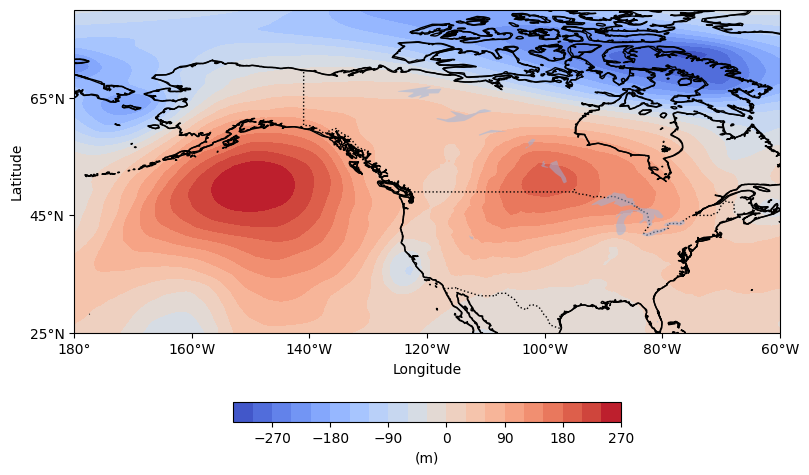

In [47]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_ec_z500_na_0629_interpolated[1,:,:]/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [48]:
#################################################### load the fcnv1_ecmwf data #############################################################################

In [23]:
#should be replaced into function to avoid the repetition
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,14,:,:]


ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,14,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,14,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,14,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,14,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,14,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,14,:,:]
ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,14,:,:]
ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,14,:,:]

In [24]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [25]:
ds_fcnv1_ec_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [26]:
ds_fcnv1_ec_z500_na_0629 = ds_fcnv1_ec_z500_na_0629_ens[:,50,:,:]
ds_fcnv1_ec_z500_na_ens_0629 = ds_fcnv1_ec_z500_na_0629_ens[:,0:50,:,:]

In [7]:
%store ds_fcnv1_ec_z500_na_0629
%store -r ds_fcnv1_ec_z500_na_ens_0629

Stored 'ds_fcnv1_ec_z500_na_0629' (DataArray)
Stored 'ds_fcnv1_ec_z500_na_ens_0629' (DataArray)


In [27]:
#interpolate the fcnv1_ec_cf onto the climatology
ds_fcnv1_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_ec_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_ec_z500_na_0629[i,:,:],clim_z500)

In [54]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!careful with kernel die
ds_fcnv1_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_ec_z500_na_ens_0629[i,j,:,:],clim_z500)

'#interpolate the fcnv1_ec_ens onto the climatology\nds_fcnv1_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)\nfor i in range(15):\n    for j in range(50):\n        ds_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_ec_z500_na_ens_0629[i,j,:,:],clim_z500)'

In [22]:
%store -r ds_fcnv1_ec_z500_na_0629_ens_interpolated

In [28]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_ec_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_fcnv1_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [24]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_ec_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

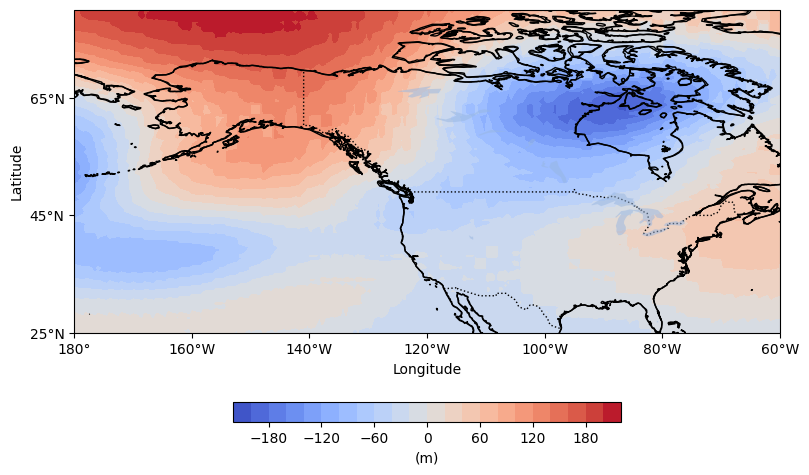

In [31]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[0,0,:,:]/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
#################################################### load fcnv1_era data ############################################################################

In [29]:
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,14,:,:]

In [30]:
variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [31]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [32]:
ds_fcnv1_era_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [33]:
ds_fcnv1_era_z500_na_0629 = ds_fcnv1_era_z500_na_0629_ens[:,0,:,:]
ds_fcnv1_era_z500_na_ens_0629 = ds_fcnv1_era_z500_na_0629_ens[:,1:51,:,:]

In [34]:
#interpolate the fcnv1_era_cf onto the climatology
ds_fcnv1_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_era_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_era_z500_na_0629[i,:,:],clim_z500)

In [ ]:
#interpolate the fcnv1_ec_ens onto the climatology
ds_fcnv1_era_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_era_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_era_z500_na_ens_0629[i,j,:,:],clim_z500)

In [5]:
%store -r ds_fcnv1_era_z500_na_0629_ens_interpolated

In [35]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_era_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_fcnv1_era_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [18]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_era_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_era_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_era_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [19]:
%store anomaly_fcnv1_era_z500_na_0629_ens_interpolated

Stored 'anomaly_fcnv1_era_z500_na_0629_ens_interpolated' (ndarray)


In [ ]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_fcnv1_era_z500_na_0629_ens_interpolated[13,16,:,:]/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [35]:
np.shape(anomaly_fcnv1_era_z500_na_0629_interpolated)

(15, 110, 240)

In [55]:
anomaly_fcnv1_ec_14 = anomaly_fcnv1_ec_z500_na_0629_interpolated[0,:,:]
anomaly_fcnv1_ec_7 = anomaly_fcnv1_ec_z500_na_0629_interpolated[7,:,:]
anomaly_fcnv1_ec_5 = anomaly_fcnv1_ec_z500_na_0629_interpolated[9,:,:]
anomaly_fcnv1_ec_3 = anomaly_fcnv1_ec_z500_na_0629_interpolated[11,:,:]

anomaly_ec_14 = anomaly_ec_z500_na_0629_interpolated[0,:,:]
anomaly_ec_7 = anomaly_ec_z500_na_0629_interpolated[7,:,:]
anomaly_ec_5 = anomaly_ec_z500_na_0629_interpolated[9,:,:]
anomaly_ec_3 = anomaly_ec_z500_na_0629_interpolated[11,:,:]

anomaly_fcnv1_era_14 = anomaly_fcnv1_era_z500_na_0629_interpolated[0,:,:]
anomaly_fcnv1_era_7 = anomaly_fcnv1_era_z500_na_0629_interpolated[7,:,:]
anomaly_fcnv1_era_5 = anomaly_fcnv1_era_z500_na_0629_interpolated[9,:,:]
anomaly_fcnv1_era_3 = anomaly_fcnv1_era_z500_na_0629_interpolated[11,:,:]

In [63]:
#anomaly_bias
#use the small batch 

anombias_fcnv1_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = anomaly_fcnv1_ec_z500_na_0629_interpolated
v1 = anomaly_era5_z500_na_0629_interpolated
for i in range(15):
   anombias_fcnv1_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,:,:],50)


In [64]:
#anomaly_bias
#use the small batch 

anombias_fcnv1_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = anomaly_fcnv1_era_z500_na_0629_interpolated
v1 = anomaly_era5_z500_na_0629_interpolated
for i in range(15):
   anombias_fcnv1_era_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,:,:],50)

In [65]:
#anomaly_bias
#use the small batch 

anombias_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = anomaly_ec_z500_na_0629_interpolated
v1 = anomaly_era5_z500_na_0629_interpolated
for i in range(15):
   anombias_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,:,:],50)

In [28]:
anombias_fcnv1_ec_14 = anombias_fcnv1_ec_z500_na_0629_interpolated[0,:,:]
anombias_fcnv1_ec_7 = anombias_fcnv1_ec_z500_na_0629_interpolated[7,:,:]
anombias_fcnv1_ec_5 = anombias_fcnv1_ec_z500_na_0629_interpolated[9,:,:]
anombias_fcnv1_ec_3 = anombias_fcnv1_ec_z500_na_0629_interpolated[11,:,:]

anombias_ec_14 = anombias_ec_z500_na_0629_interpolated[0,:,:]
anombias_ec_7 = anombias_ec_z500_na_0629_interpolated[7,:,:]
anombias_ec_5 = anombias_ec_z500_na_0629_interpolated[9,:,:]
anombias_ec_3 = anombias_ec_z500_na_0629_interpolated[11,:,:]

anombias_fcnv1_era_14 = anombias_fcnv1_era_z500_na_0629_interpolated[0,:,:]
anombias_fcnv1_era_7 = anombias_fcnv1_era_z500_na_0629_interpolated[7,:,:]
anombias_fcnv1_era_5 = anombias_fcnv1_era_z500_na_0629_interpolated[9,:,:]
anombias_fcnv1_era_3 = anombias_fcnv1_era_z500_na_0629_interpolated[11,:,:]

NameError: name 'anombias_fcnv1_ec_z500_na_0629_interpolated' is not defined

In [38]:
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)
x, y = lon_grid, lat_grid  

In [ ]:
#################################################### plot the anomaly distribution ################################################

In [ ]:
rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='blue', facecolor='none')

In [161]:
rect = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')

In [162]:
#ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
red_point_lon = -121.50
red_point_lat = 50.25

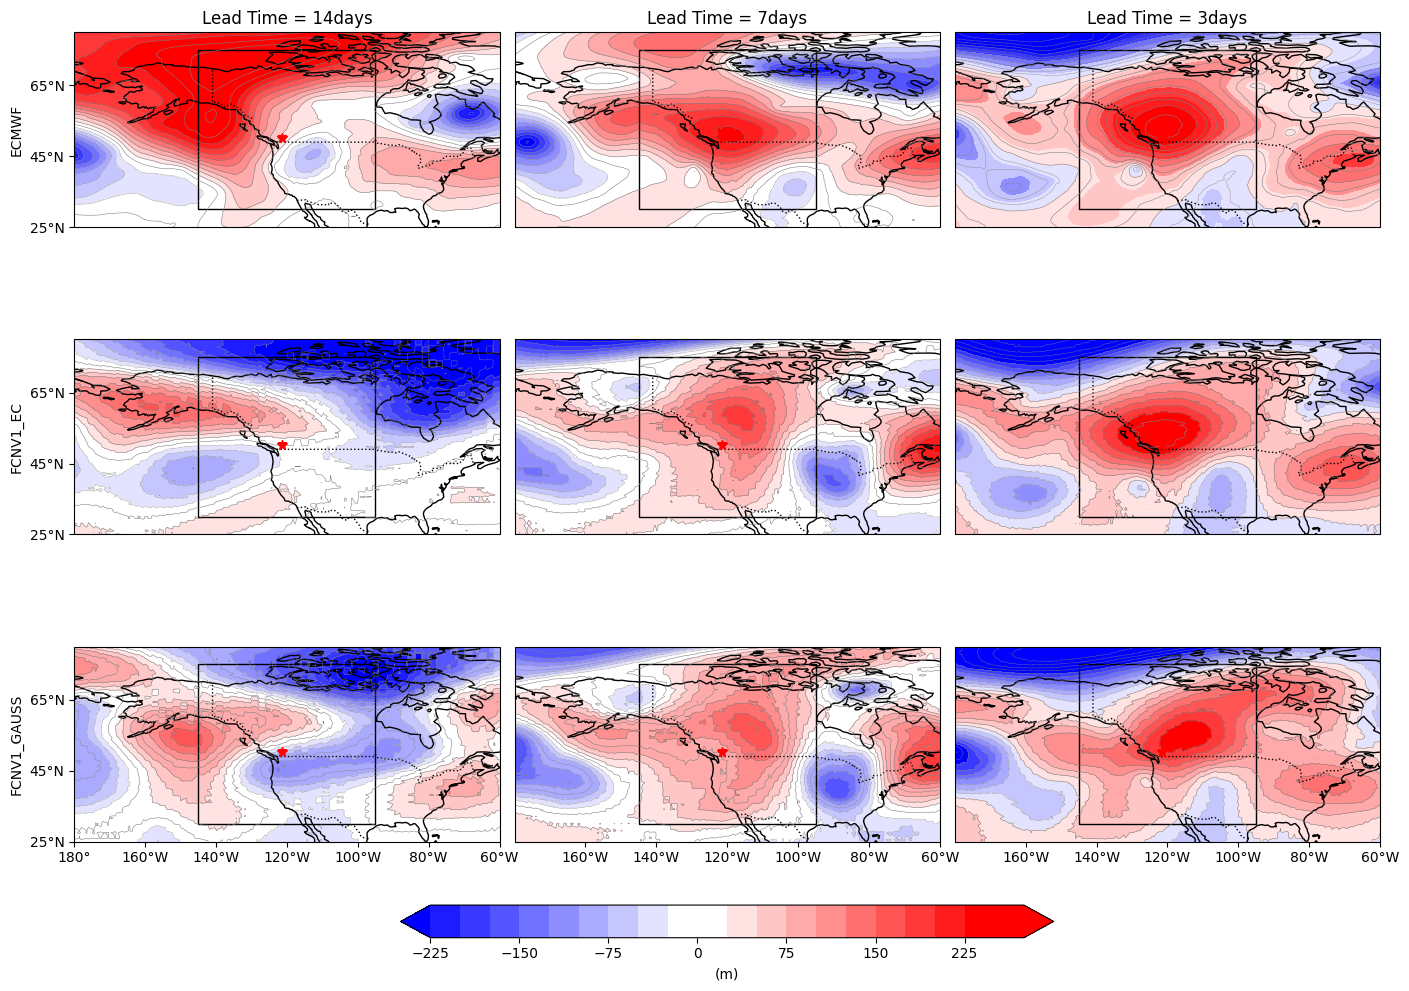

In [163]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=19,
                                                 )



#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())/9.80665
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())/9.80665
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=-500, vcenter=0, vmax=100)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 20,vmin = -250,vmax = 250)
#cmap=cmap, norm=norm8
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,anomaly_ec_14/9.80665,**plot_kwargs,extend = 'both')
contour4_1 = ax1.contour(x,y,anomaly_ec_14/9.80665, levels=22,colors = 'grey',linewidths =0.4)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')
ax1.add_patch(rect)
ax1.plot(red_point_lon, red_point_lat, 'r*', markersize=7)


ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')

contour2 = ax2.contourf(x,y,anomaly_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax2.contour(x,y,anomaly_ec_7/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax2.add_patch(rect_1)
ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')

contour3 = ax3.contourf(x,y,anomaly_ec_3/9.80665,**plot_kwargs)
contour3_1 = ax3.contour(x,y,anomaly_ec_3/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax3.add_patch(rect_2)
ax3.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,anomaly_fcnv1_ec_14/9.80665,**plot_kwargs)
contour4_1 = ax4.contour(x,y,anomaly_fcnv1_ec_14/9.80665, levels=22,colors = 'grey',linewidths =0.4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FCNV1_EC')
ax4.add_patch(rect_3)
ax4.plot(red_point_lon, red_point_lat, 'r*', markersize=7)


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')

leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,anomaly_fcnv1_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax5.contour(x,y,anomaly_fcnv1_ec_7/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax5.add_patch(rect_4)
ax5.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,anomaly_fcnv1_ec_3/9.80665,**plot_kwargs)
contour4_1 = ax6.contour(x,y,anomaly_fcnv1_ec_3/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax6.add_patch(rect_5)
ax6.plot(red_point_lon, red_point_lat, 'r*', markersize=7)


ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FCNV1_GAUSS')
contour4 = ax7.contourf(x,y,anomaly_fcnv1_era_14/9.80665,**plot_kwargs)
contour4_1 = ax7.contour(x,y,anomaly_fcnv1_era_14/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax7.add_patch(rect_6)
ax7.plot(red_point_lon, red_point_lat, 'r*', markersize=7)


ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,anomaly_fcnv1_era_7/9.80665,**plot_kwargs)
contour4_1 = ax8.contour(x,y,anomaly_fcnv1_era_7/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax8.add_patch(rect_7)
ax8.plot(red_point_lon, red_point_lat, 'r*', markersize=7)



ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)


contour4 = ax9.contourf(x,y,anomaly_fcnv1_era_3/9.80665,**plot_kwargs)
contour4_1 = ax9.contour(x,y,anomaly_fcnv1_era_3/9.80665, levels=22,colors = 'grey',linewidths =0.4)
ax9.add_patch(rect_8)
ax9.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
#contour4_1 = ax9.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=20,colors = 'black',linewidths =0.3)
#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, shrink=0.5,label='(m)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/3*3_ANOMALY_z500_1473_withrecstar.png', bbox_inches='tight',dpi=150)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

In [ ]:
#################################################### plot the anomaly distribution ################################################

In [19]:
#colorbar setting
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.dpi = 300
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [20]:
from matplotlib.colors import LinearSegmentedColormap
my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#10:14146E-20:1529D4-30:2F66B9-48:FFFFFF-52:FFFFFF-70:BA5B05-80:CC0A00-90:852800
      (0.000, (0.078, 0.078, 0.431)),
    (0.100, (0.078, 0.078, 0.431)),
    (0.200, (0.082, 0.161, 0.831)),
    (0.300, (0.184, 0.400, 0.725)),
    (0.460, (1.000, 1.000, 1.000)),
    (0.540, (1.000, 1.000, 1.000)),
    (0.700, (0.937, 0.455, 0.012)),
    (0.800, (0.953, 0.373, 0.224)),
    (0.900, (0.906, 0.000, 0.078)),
    (1.000, (0.906, 0.000, 0.078))))

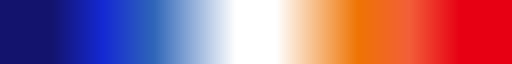

In [21]:
my_gradient

In [22]:
value = (bad_forecast_3-good_forecast_3)/9.80665
np.max(value)

NameError: name 'bad_forecast_3' is not defined

In [23]:
mid_point = (np.max(value))/((np.abs(np.min(value)))+(np.max(value)))

1-mid_point

NameError: name 'value' is not defined

In [26]:
orig_cmap= my_gradient
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.4 ,name='shifted_80')

/scratch/slurm_tmpdir/job_23769021/ipykernel_73226/1069867171.py:57: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


NameError: name 'anombias_ec_14' is not defined

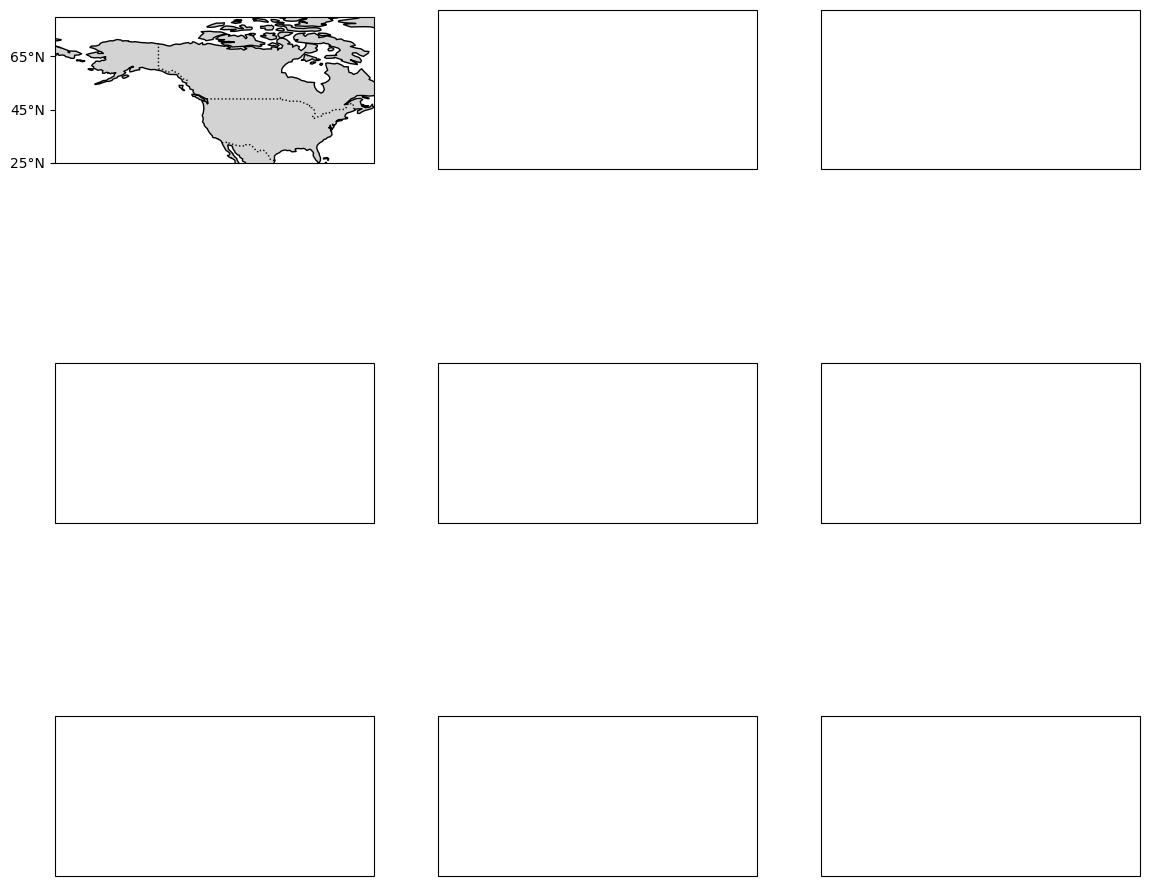

In [27]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = shifted_cmap



#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())/9.80665
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())/9.80665
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=-500, vcenter=0, vmax=100)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 21,vmin = -300,vmax =430)
#cmap=cmap, norm=norm8
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,anombias_ec_14/9.80665,**plot_kwargs,extend = 'both')
contour4_1 = ax1.contour(x,y,anomaly_ec_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax1.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')
ax1.add_patch(rect)


ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')
contour2 = ax2.contourf(x,y,anombias_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax2.contour(x,y,anomaly_ec_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax2.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')
contour3 = ax3.contourf(x,y,anombias_ec_3/9.80665,**plot_kwargs)
contour4_1 = ax3.contour(x,y,anomaly_ec_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax3.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480
ax3.add_patch(rect_2)
#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,anombias_fcnv1_ec_14/9.80665,**plot_kwargs)
contour4_1 = ax4.contour(x,y,anomaly_fcnv1_ec_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax4.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FCNV1_EC')
plt.tight_layout()
ax4.add_patch(rect_3)

#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,anombias_fcnv1_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax5.contour(x,y,anomaly_fcnv1_ec_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax5.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,anombias_fcnv1_ec_3/9.80665,**plot_kwargs)
contour4_1 = ax6.contour(x,y,anomaly_fcnv1_ec_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax6.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax6.add_patch(rect_5)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FCNV1_GAUSS')
contour4 = ax7.contourf(x,y,anombias_fcnv1_era_14/9.80665,**plot_kwargs)
contour4_1 = ax7.contour(x,y,anomaly_fcnv1_era_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax7.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,anombias_fcnv1_era_7/9.80665,**plot_kwargs)
contour4_1 = ax8.contour(x,y,anomaly_fcnv1_era_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax8.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax8.add_patch(rect_7)

ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,anombias_fcnv1_era_3/9.80665,**plot_kwargs)
contour4_1 = ax9.contour(x,y,anomaly_fcnv1_era_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax9.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax9.add_patch(rect_8)
#contour4_1 = ax9.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=20,colors = 'black',linewidths =0.3)
#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, shrink=0.5,label='(m)',pad = 0.05,extend = 'both')
#plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/3*3_ANOMBIAS_z500_1473withrec.png', bbox_inches='tight',dpi=150)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

In [24]:
rect = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-145.0,30.0),50,45, linewidth=1, edgecolor='black', facecolor='none')

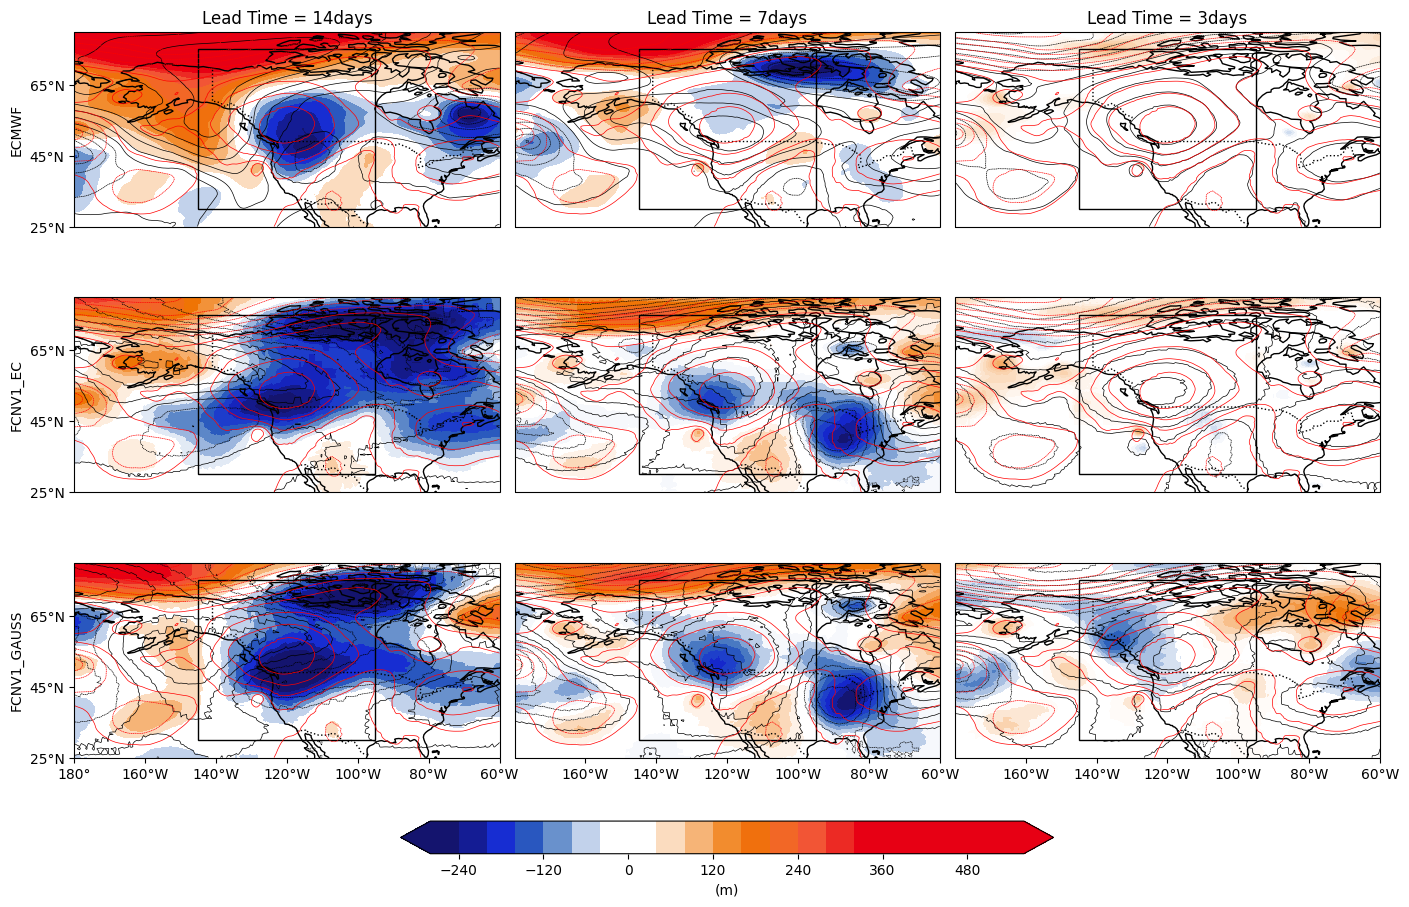

In [172]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = shifted_cmap



#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())/9.80665
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())/9.80665
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=-500, vcenter=0, vmax=100)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 21,vmin = -300,vmax =430)
#cmap=cmap, norm=norm8
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,anombias_ec_14/9.80665,**plot_kwargs,extend = 'both')
contour4_1 = ax1.contour(x,y,anomaly_ec_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax1.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')
ax1.add_patch(rect)


ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')
contour2 = ax2.contourf(x,y,anombias_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax2.contour(x,y,anomaly_ec_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax2.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')
contour3 = ax3.contourf(x,y,anombias_ec_3/9.80665,**plot_kwargs)
contour4_1 = ax3.contour(x,y,anomaly_ec_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax3.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480
ax3.add_patch(rect_2)
#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,anombias_fcnv1_ec_14/9.80665,**plot_kwargs)
contour4_1 = ax4.contour(x,y,anomaly_fcnv1_ec_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax4.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FCNV1_EC')
plt.tight_layout()
ax4.add_patch(rect_3)

#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,anombias_fcnv1_ec_7/9.80665,**plot_kwargs)
contour4_1 = ax5.contour(x,y,anomaly_fcnv1_ec_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax5.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,anombias_fcnv1_ec_3/9.80665,**plot_kwargs)
contour4_1 = ax6.contour(x,y,anomaly_fcnv1_ec_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax6.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax6.add_patch(rect_5)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FCNV1_GAUSS')
contour4 = ax7.contourf(x,y,anombias_fcnv1_era_14/9.80665,**plot_kwargs)
contour4_1 = ax7.contour(x,y,anomaly_fcnv1_era_14/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax7.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,anombias_fcnv1_era_7/9.80665,**plot_kwargs)
contour4_1 = ax8.contour(x,y,anomaly_fcnv1_era_7/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax8.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax8.add_patch(rect_7)

ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,anombias_fcnv1_era_3/9.80665,**plot_kwargs)
contour4_1 = ax9.contour(x,y,anomaly_fcnv1_era_3/9.80665, levels=11,colors = 'black',linewidths =0.5)
contour4_1 = ax9.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=11,colors = 'red',linewidths =0.5)
ax9.add_patch(rect_8)
#contour4_1 = ax9.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=20,colors = 'black',linewidths =0.3)
#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, shrink=0.5,label='(m)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/3*3_ANOMBIAS_z500_1473withrec.png', bbox_inches='tight',dpi=150)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

In [ ]:
####################################### THE ANOMALY OF ERA5 Z500############################################################################

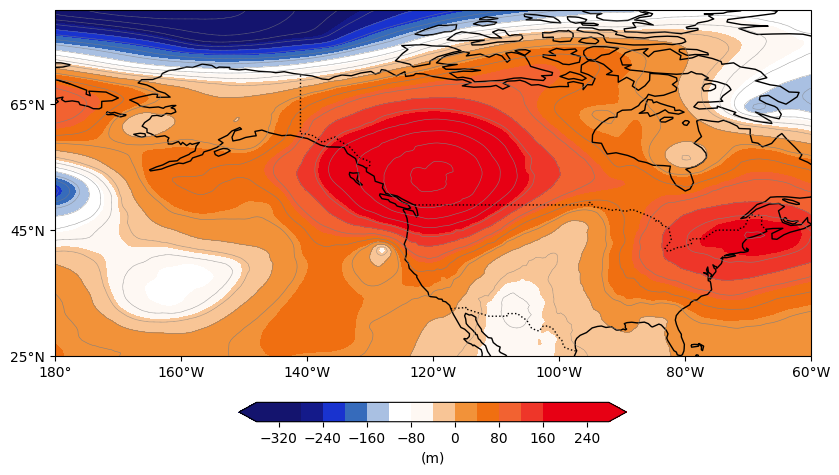

In [131]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig = plt.figure(figsize=(10,6))
#proj = ccrs.PlateCarree(central_longitude=-120)
#ax = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax = plt.axes(projection=ccrs.PlateCarree())
#proj = ccrs.PlateCarree(central_longitude=-120) 


cmap = shifted_cmap



#vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())/9.80665
#vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())/9.80665
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
#norm = TwoSlopeNorm(vmin=-500, vcenter=0, vmax=100)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap,levels = 21,vmin = -320,vmax = 250)
#cmap=cmap, norm=norm8
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,**plot_kwargs,extend = 'both')
contour4_1 = ax.contour(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665, levels=22,colors = 'grey',linewidths =0.4)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
#ax.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
#ax.set_ylabel('ECMWF')
#ax1.add_patch(rect)
cbar = plt.colorbar(contour1, ax=ax, orientation='horizontal', cmap=cmap, shrink=0.5,label='(m)',pad = 0.1,extend = 'both')
#plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/3*3_ANOMBIAS_z500_1473.png', bbox_inches='tight',dpi=150)